<a href="https://colab.research.google.com/github/vaishnavipatil29/Emotion-Detection-/blob/main/Copy_of_Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Recognition**

### Importing Libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df = pd.read_csv('/content/drive/My Drive/sem-6/NNDL/fer2013.csv')
df = pd.read_csv('/content/drive/My Drive/fer2013.csv')

The data consists of 48×48 pixel gray scale images of faces.The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

No. of training examples : 35887

Total features/pixels (columns) : 2304 [48x48]

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### Visualize Dataset

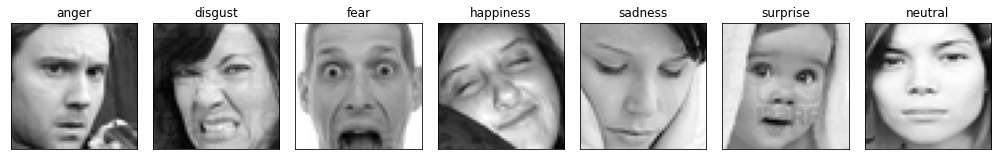

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

### Input and Output Data

In [ ]:
X = df.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(df['emotion'])

In [ ]:
X.shape

(35887, 2304)

In [ ]:
Y.shape

(35887,)

# Preprocessing


Step 1: Cascade Object Detection : 

Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. 

Haar Cascade Classifier in OpenCV already contains many pre-trained classifiers for face, eyes, smile etc.



In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

Step 2: Face Alignment:

Face alignment is used to improve the accuracy of face recognition. It is a normalized technique which outputs the face-centered to the image, rotated such that line joining the center of two eyes is parallel to the horizontal line and it resizes the faces to identical scale.

xywh.png


In [ ]:
def face_align(gray):
  sz = gray.shape
  # Creating variable eyes
  #detectMultiScale : Detects objects of different sizes in the input image. The detected objects are returned as a list of rectangles.
  eyes = eye_cascade.detectMultiScale(gray, 1.3, 5) 
  #scaleFactor – Parameter specifying how much the image size is reduced at each image scale. : 1.3
  #minNeighbors – Parameter specifying how many neighbors each candidate rectangle should have to retain it : 5
  if len(eyes) > 1 :
    index=0
    # Creating for loop in order to divide one eye from another
    for (ex , ey,  ew,  eh) in eyes: 
    #For eyes, the positions of detected eyes are as a rectangle with the left up corner (x,y) and having “w” as its Width and “h” as its Height ==> (x,y,w,h).
      if index == 0:
        eye_1 = (ex, ey, ew, eh)
      elif index == 1:
        eye_2 = (ex, ey, ew, eh)
      index += 1
    if eye_1[0] < eye_2[0]: #if the left up corner has less x coordinate, it will be the left eye
      left_eye = eye_1
      right_eye = eye_2
    else:
      left_eye = eye_2
      right_eye = eye_1
        
    # Calculating coordinates of a central points of the rectangles
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2))) # (x+w)/2 , (y+h)/2 are central coordinates of eyes 
    left_eye_x = left_eye_center[0] 
    left_eye_y = left_eye_center[1]
        
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]
    right_eye_y = right_eye_center[1]

    if left_eye_y > right_eye_y:
      A = (right_eye_x, left_eye_y)
      # Integer -1 indicates that the image will rotate in the clockwise direction
      direction = -1 
    else:
      A = (left_eye_x, right_eye_y)
      # Integer 1 indicates that image will rotate in the counter clockwise direction
      direction = 1 
        
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi

    # Width and height of the image
    h, w = gray.shape[:2]
    # Calculating a center point of the image
    # Integer division "//"" ensures that we receive whole numbers
    center = (w // 2, h // 2)
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    # Applying the rotation to our image using the
    # cv2.warpAffine method
    gray = cv2.warpAffine(gray, M, (w, h))

    #Again detecting face
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0 : 
      (x,y,w,h) = faces[0]
      gray = gray[y:y+h, x:x+w]

  gray = cv2.resize(gray,sz) 
  return gray

In [ ]:
X_new = []
for j in range(X.shape[0]):
  px = np.array(X[j]).reshape(48,48)
  px = np.array(px, dtype='uint8')
  px_new = face_align(px)
  X_new.append(np.array(px).reshape(48*48))
X = np.array(X_new)

### Train and Test Split for KNN and SVM


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 2304), (7178, 2304), (28709,), (7178,))

###PCA to retain 95% variation and reduce dataset size

An important machine learning method for dimensionality reduction is called Principal Component Analysis. It is a method that uses simple matrix operations from linear algebra and statistics to calculate a projection of the original data into the same number or fewer dimensions.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))  #fit_transform do a calculation and fitting data on the training set,
#then the same calculation can be directly used in validation set by using transform.
X_valid = scaler.transform(X_valid.astype(np.float32))
#95% of variance
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))
X_train_p.shape ,X_test_p.shape 


((28709, 269), (7178, 269))

1.Fit(): Method calculates the parameters μ and σ and saves them as internal objects.
2.Transform(): Method using these same parameters apply the transformation to a particular dataset.
3.Fit_transform(): joins the fit() and transform() method for transformation of dataset.

For a given data set there will be only one mean and one standard deviation, which can be represented by training data set.

μ-mean
σ-standard deviation

therefore, fit_transform(X_train) calculated μ and σ on training data set. The same factors will be used by the transform() function.

# SVM

####Using Linear kernel

In [ ]:
model = SVC(kernel = 'linear')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.3743382557815548

####Using rbf kernel

In [ ]:
model = SVC(kernel ='rbf')
model.fit(X_train_p,y_train)
model.score(X_test_p , y_valid)

0.4605739760378936

# KNN

neighbour = 1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)
classifier.score(X_valid,y_valid)

0.40540540540540543

In [ ]:
start_time = time.time()
y_pred = classifier.predict(X_valid)
print("Time Taken : %s seconds " % (time.time() - start_time))

Time Taken : 945.4951930046082 seconds 


In [ ]:
cnt = 0
for i in range(X_valid.shape[0]):
   cnt += y_pred[i] == y_valid[i]
print("Accuracy :", cnt/X_valid.shape[0]*100, "%")

Accuracy : 40.54054054054054 %


####KNN using default parameters

In [ ]:
knn = KNeighborsClassifier() # default is 5
knn.fit(X_train_p ,y_train)
knn.score(X_test_p,y_valid)

0.26804123711340205

knn neighbours = 3

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
classifier.score(X_valid,y_valid)

0.3492616327667874

**ML Algorithms Comparison**

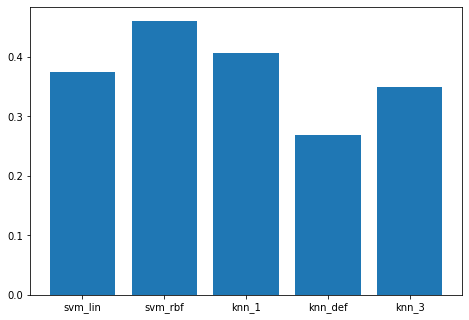

In [ ]:
svm_lin = 0.3743382557815548
svm_rbf_ker = 0.4605739760378936
knn_1 = 0.40540540540540543
knn_def = 0.26804123711340205
knn_3 = 0.3492616327667874

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
algorithm = ['svm_lin', 'svm_rbf', 'knn_1', 'knn_def', 'knn_3']
accuracy = [svm_lin,svm_rbf_ker,knn_1,knn_def,knn_3]
ax.bar(algorithm,accuracy)
plt.show()